In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from groundingdino.util import inference
from sam2.build_sam import build_sam2
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
from openai.simple_tokenizer import SimpleTokenizer
import regex as re
import ftfy
from torchvision.ops import box_convert
import html
import pycocotools.mask as coco_mask
# 设备选择
device = torch.device("cuda")

In [82]:
# 加载SAM模型(model_cfg从build_sam2所在开始计算)
sam2_checkpoint = "../third_party/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# 均匀采样SAM
rough_mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=18,
    points_per_batch=9,
    pred_iou_thresh=0.43,
    stability_score_thresh=0.43,
    stability_score_offset=0.43,
    crop_n_layers=0,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=5,
    use_m2m=False,
)

# 点指定采样SAM
specific_mask_predictor = SAM2ImagePredictor(
    sam_model=sam2,
    mask_threshold=0.0,
    max_hole_area=0.15,
    max_sprinkle_area=0.15,
)


In [3]:
# 加载clip模型
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")  # clip模型
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14") # 生成器

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [4]:
# 加载dino(路径是从该程序开始计算)
dino = inference.load_model("../third_party/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "../third_party/GroundingDINO/weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


In [6]:
tasks = ['close_jar', 'meat_off_grill', 'open_drawer', 'reach_and_drag']

In [71]:
# 根据任务进行读取
task = tasks[3]
task_description = 'The RobotArm is instructed to ' + task

# 读取image
images = []
images_input = []
images_dino_input = []
image_choose = [0, 3, 5, 7, 11, 15, 18, 20]
for i in image_choose:
    IMAGE_PATH = 'images/' + task + f'/{i}.png'

    image = Image.open(IMAGE_PATH)
    image_input = np.array(image.convert("RGB"))
    images.append(image)
    images_input.append(image_input)
    image_source, image_dino_input = inference.load_image(IMAGE_PATH)
    images_dino_input.append(image_dino_input)


In [72]:
# 处理lang_prompt
def basic_clean(text):
    text = ftfy.fix_text(text)  # 修复文本编码问题
    text = html.unescape(html.unescape(text))  # 处理 HTML 转义字符
    return text.strip()

def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)  # 将连续空白字符替换为单个空格
    text = text.strip()  # 去除开头和结尾的空白字符
    return text

def remove_underscores(text):
    text = re.sub(r'_', ' ', text)  # 将下划线替换为空格
    return text

def preprocess_text(text):
    text = basic_clean(text)
    text = whitespace_clean(text)
    text = remove_underscores(text)
    text = text.lower()  # 转换为小写
    pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)
    tokens = re.findall(pat, text)
    return tokens

def prompt_augment(text):
    verbs = []
    nouns = []
    augment_prompt = []
    import spacy
    # 加载英语模型
    nlp = spacy.load("../third_party/en_core_web_sm-3.8.0/en_core_web_sm/en_core_web_sm-3.8.0")
    doc = nlp(text)
        
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]    
    # for verb in verbs:
    #     if verb != 'instructed':
    #         verb_augment = 'a item that can be moved for "' + verb + '" operation'
    #         augment_prompt.append(verb_augment)

    augment_prompt = augment_prompt + nouns
    augment_prompt.append("manipulation object")  
    augment_prompt.append("tiny object") 
    augment_prompt.append("claw") 
    # augment_prompt.append("yellow desk")
    return augment_prompt
    

# 预处理文本获得去掉特殊符号后的分词模型(去除下划线和空格等，并统一为小写)
cleaned_text = preprocess_text(task_description)
panoptic_description = " ".join(cleaned_text)

'''
    1. 使用clip获得任务的全局文本描述embedding(the robotarm is instructed to close jar-> torch.Size([1, 768])) : lang_embedding
'''
panoptic_inputs = processor(text=panoptic_description, return_tensors="pt")
lang_embedding = clip.get_text_features(**panoptic_inputs)
# print(lang_embedding.shape)

'''
    2. 获得prompt(the robotarm is instructed to close jar -> ['a item that can be moved for "close" operation', 'robotarm', 'jar', 'table'])) : mani_words
'''

# # 去除介词和连接词，并进行propmt增强
# stopwords = {"a", "the", "and", "an", "of", "in", "on", "at", "to", "with", "for", "by"}    # 去除task_description中的连接词与介词
mani_words = prompt_augment(panoptic_description)
print(panoptic_description)
print(mani_words)
    
'''
    3. 获得场景操作(包含一些物体以及action)的token (['robotarm', 'close', 'jar'] -> torch.Size([3, 768])) : mani_tokens
'''
with torch.no_grad():
    mani_tokens = torch.empty((0, 768))
    # for mani_word in mani_words:
    #     inputs = processor(text=mani_word , return_tensors="pt")
    #     mani_tokens = torch.cat((mani_tokens, clip.get_text_features(**inputs)), dim=0)
    # print(mani_tokens.shape)



the robotarm is instructed to reach and drag
['robotarm', 'manipulation object', 'tiny object', 'claw']


In [ ]:
def show_mask(mask, ax, random_color=False, borders = False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:100

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))  

In [11]:
def filter_overlapping_masks(masks, overlap_threshold=0.5):
    """
    过滤掉重叠的 mask，只保留最大的，如果交集面积超过其中一个mask面积的50%，则删除
    :param masks: mask annotations (list of np arrays)
    :param overlap_threshold: 重叠阈值，超过该值的mask将被删除
    :return: 过滤后的 mask annotations
    """
    filtered_masks = []
    num_masks = len(masks)
    visited = set()
    add = set()

    for i in range(num_masks):
        if i in visited:
            continue  # 如果已经被筛除，则跳过

        max_mask = masks[i]
        max_area = np.sum(max_mask)  # 计算 mask 的面积
        max_index = i

        # 启动新的检查循环，确保重新更新的 max_mask 被检查
        for j in range(num_masks):  # 对所有 masks 重新进行遍历
            if j == i:
                continue

            mask_a = max_mask
            mask_b = masks[j]

            # 计算交叠部分
            intersection = np.logical_and(mask_a, mask_b)
            intersection_area = np.sum(intersection)

            if intersection_area > 0:  # 有交集
                area_a = np.sum(mask_a)
                area_b = np.sum(mask_b)
                # 判断交集是否超过任意一个mask的60%
                if intersection_area / area_a > overlap_threshold or intersection_area / area_b > overlap_threshold:
                    visited.add(j)  # 标记被筛除的 mask

                    # 保留更大的 mask
                    if area_b > max_area:
                        max_mask = masks[j]
                        max_area = area_b
                        max_index = j

        if max_index not in add:
            # 把最终选择的最大 mask 加入到过滤后的列表
            filtered_masks.append(max_mask)
            add.add(max_index)

    return filtered_masks
def selective_merge_masks(masks, min_area=300, kernel_size=3):
    small_blocks = []
    other_masks = []

    # 根据面积分类 mask
    for mask in masks:
        mask = mask.squeeze().astype(bool)  # 转换为布尔类型
        area = np.sum(mask)
        if area < min_area:
            small_blocks.append(mask)
        else:
            other_masks.append(mask)

    if not small_blocks:
        return masks  # 没有小块，直接返回

    # 获取图像尺寸
    height, width = small_blocks[0].shape
    combined_mask = np.zeros((height, width), dtype=bool)  # 确保是布尔类型
    # 叠加所有小块
    for block_img in small_blocks:
        combined_mask |= block_img.astype(bool)  # 确保 `block_img` 也是布尔值

    # 形态学闭运算合并相邻的小块
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    merged_mask = cv2.morphologyEx(combined_mask.astype(np.uint8) * 255, cv2.MORPH_CLOSE, kernel) > 0

    # 进行连通组件分析
    num_labels, labels = cv2.connectedComponents(merged_mask.astype(np.uint8))

    filtered_masks = other_masks.copy()
    for i in range(1, num_labels):
        single_mask = labels == i  # 获取某个连通区域

        # 选择最大区域的小块
        max_area = 0
        selected_mask = None
        for block in small_blocks:
            overlap = np.logical_and(single_mask, block)
            overlap_area = np.sum(overlap)
            if overlap_area > 0 and np.sum(block) > max_area:
                max_area = np.sum(block)
                selected_mask = block

        # 如果找到了最佳 mask，添加进结果
        if selected_mask is not None:
            filtered_masks.append(single_mask)
        else:
            filtered_masks.append(single_mask)

    return filtered_masks

import numpy as np
from PIL import Image

def extract_masked_objects(image, masks, padding=3):
    height, width = image.shape[:2]
    extracted_objects = []

    for mask in masks:
        if mask is None or mask.size == 0:
            continue

        mask = mask.squeeze().astype(bool)
        y_indices, x_indices = np.where(mask)
        if len(x_indices) == 0 or len(y_indices) == 0:
            continue

        x1, x2 = max(x_indices.min() - padding, 0), min(x_indices.max() + padding, width)
        y1, y2 = max(y_indices.min() - padding, 0), min(y_indices.max() + padding, height)

        # 复制原图
        masked_img = np.array(image, dtype=np.uint8)
        masked_img[masked_img == 0] = 235  # 这里是让黑色部分变色，从而避免与背景混淆丢失黑色物体的识别

        # 让 mask 之外的部分变为 0
        masked_img[~mask] = 0
        
        # 裁剪目标区域
        cropped_img = masked_img[y1:y2, x1:x2]
        pil_img = Image.fromarray(cropped_img)

        # 存储原始坐标
        pil_img.info["bbox"] = (x1, y1, x2, y2)
        pil_img.info['numpy_ver'] = cropped_img
        extracted_objects.append(pil_img)

    return extracted_objects



def compute_bbox(mask):
    """
    计算 mask 的边界框 (bounding box)
    :param mask: 形状为 (H, W) 的 numpy 数组，值为 0 或 1
    :return: (x1, y1, x2, y2, width, height)
    """
    y_indices, x_indices = np.where(mask)  # 获取所有 1 的坐标

    if len(x_indices) == 0 or len(y_indices) == 0:
        return None  # 说明 mask 里全是 0，没有 1

    # 计算边界
    x1, x2 = x_indices.min(), x_indices.max()
    y1, y2 = y_indices.min(), y_indices.max()

    # 计算宽度和高度
    width = x2 - x1 + 1
    height = y2 - y1 + 1

    return x1, y1, x2, y2, width, height


In [74]:
TEXT_PROMPT = " . ".join(mani_words) + "."
BOX_TRESHOLD = 0.18
TEXT_TRESHOLD = 0.2
print(TEXT_PROMPT)

robotarm . manipulation object . tiny object . claw.


robotarm . manipulation object . tiny object . claw.


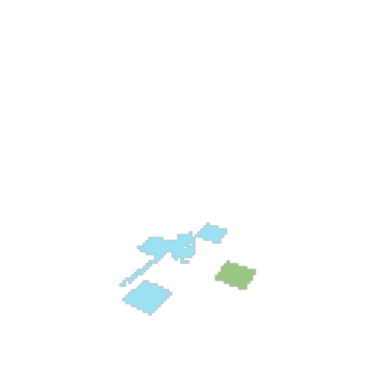

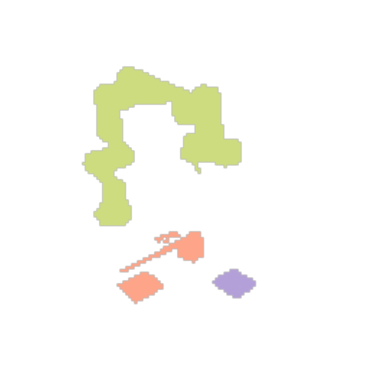

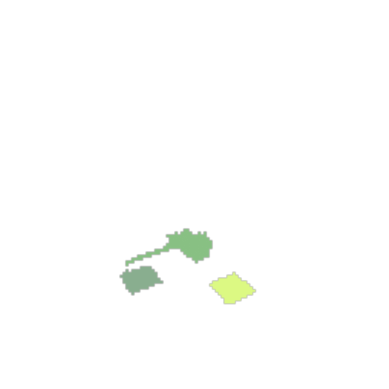

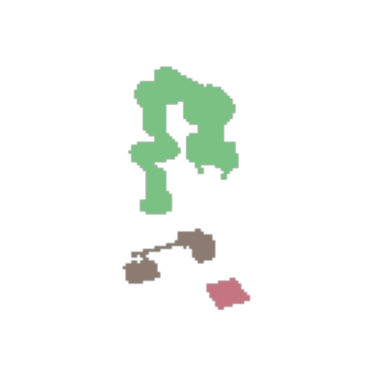

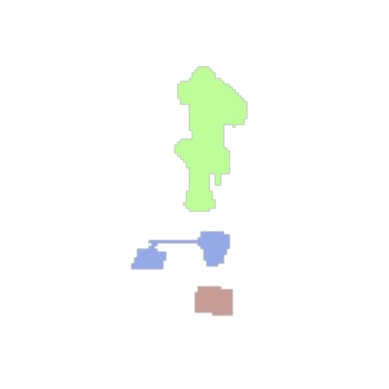

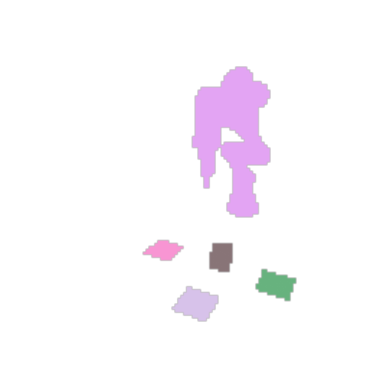

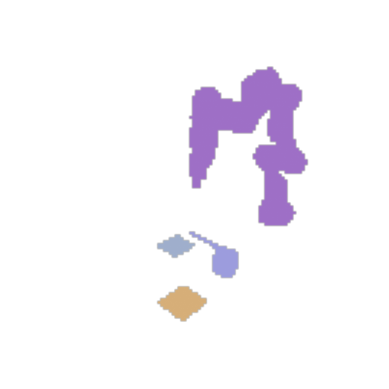

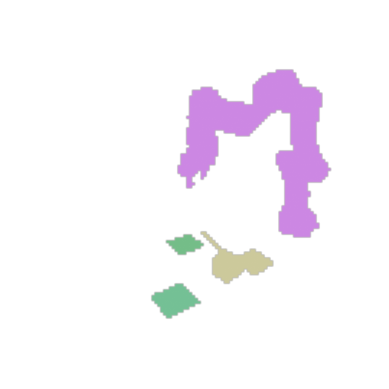

In [75]:
print(TEXT_PROMPT)

multi_view_masks = []
multi_view_maksed_images = []
multi_view_nums = len(image_choose)

for i in range(multi_view_nums):
    image, image_input, image_dino_input  = images[i], images_input[i], images_dino_input[i]
    '''

        先使用dino提取出场景中操作相关的box

    '''
    boxes, logits, phrases = inference.predict(
        model=dino,
        image=image_dino_input,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    annotated_frame = inference.annotate(image_source=image_input, boxes=boxes, logits=logits, phrases=phrases)
    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    '''

        再将box送入sam2生成masks

    '''    
    specific_mask_predictor.set_image(image)
    rough_masks, scores, _ = specific_mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=boxes_xyxy,
        multimask_output=False,
    )
        
    # print(len(rough_masks))
    # plt.figure(figsize=(10, 10))
    # plt.imshow(image)
    # for mask in rough_masks:
    #     show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    # for box in boxes_xyxy:
    #     show_box(box, plt.gca())
    # plt.axis('off')
    # plt.show()
    '''

        优化masks

    '''    
    
    _masks = []
    # 先根据本阈值筛选，去掉大片背景
    for single_mask in rough_masks:
        if np.count_nonzero(single_mask) / (128 * 128) > 0.2 or np.count_nonzero(single_mask) / (128 * 128) < 0.002:
            continue
        _masks.append(single_mask)
    # 过滤重复部分，重复率超50%就删除
    filtered_masks = filter_overlapping_masks(_masks, 0.5)
    # 相邻的多块连通的mask合并，像素低于200的才会合并
    merged_masks =  selective_merge_masks(filtered_masks, 200)
 
   
    masks = []
    
    # print(len(merged_masks))
    
    # 再进行一次筛选
    for mask in merged_masks:
        mask = mask.squeeze()
        _, _, _, _, width, heigth = compute_bbox(mask)
        # 长/宽覆盖超过90%的去除，这必然是背景
        if width / 128 > 0.9 or heigth / 128 > 0.9:
            continue
        # 长/宽覆盖低于2%的去除，这必然是碎片
        if width / 128 < 0.02 or heigth / 128 < 0.02:
            continue
        masks.append(mask)
        
   #  print(len(masks))
    
    if len(masks) < 1:
        masks = merged_masks
        
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    # 获得分割后的子部分单独展示
    masked_images = extract_masked_objects(image_input, masks)
    # for obj in masked_images:
    #     plt.figure()
    #     plt.imshow(obj)
    #     plt.axis("off")
    #     plt.show()
    plt.show()
    
    '''
        这里最终获得的是 masks 和 masked_images
        masks是np.shape(128, 128)的二值矩阵
        masked_images是每个框出来物体的真实RGB图，底版为透明
    '''
    multi_view_masks.append(masks)
    multi_view_maksed_images.append(masked_images)

In [76]:
def map_masks_to_original(masks, box, original_shape):
    x1, y1, x2, y2 = box  # 目标框坐标
    H, W, _ = original_shape  # 原图尺寸
    
    # 创建原图大小的二值矩阵
    masks_original = np.zeros((H, W), dtype=np.uint8)

    # 将分割结果填充到对应区域
    masks_original[y1:y2, x1:x2] = masks

    return masks_original

In [77]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [78]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union  = np.logical_or(mask1, mask2).sum()
    iou = intersection / union
    return iou if union > 0 else 0    
    
def filter_large_duplicate_masks(masks, ios_threshold=0.5):
    """
    过滤掉大面积的重复 mask，仅保留较小的 mask
    :param masks: 只包含 segmentation 的二值 numpy 数组列表
    :param ios_threshold: IoS 阈值（0~1）
    :return: 经过筛选后的 masks 列表
    """

    def compute_max_ios(mask1, mask2):
        """计算两个 mask 之间的最大 IoS（以较小的面积为分母）"""
        intersection = np.logical_and(mask1, mask2).sum()
        area1 = np.count_nonzero(mask1)
        area2 = np.count_nonzero(mask2)
        
        if area1 == 0 or area2 == 0:
            return 0  # 避免除零错误
        
        ios = intersection / min(area1, area2)  # 归一化到较小的区域
        
        return ios
    
    iterable = True
    
    while iterable:

        iterable = False
        masks = sorted(masks, key=lambda x: np.count_nonzero(x), reverse=False)
        
        filtered_masks = []
        
        for i in range(len(masks)):
            mask_i = masks[i]
            keep = True  # 默认保留

            for mask_j in filtered_masks:
                max_ios = compute_max_ios(mask_i, mask_j)

                if max_ios > ios_threshold:  # IoS 超过阈值，说明 mask_i 被 mask_j 包含
                    keep = False
                    
                    # 这时候处理一下mask[i]，因为根据这个从小到大的顺序，当前mask_i一定大于mask_j
                    masks[i] = np.logical_and(mask_i, np.logical_not(mask_j))
                    iterable = True
                    
                    break  # 直接跳出，mask_i 不需要保留了

            if keep:
                filtered_masks.append(mask_i)  # 只保留小的 mask

    return filtered_masks


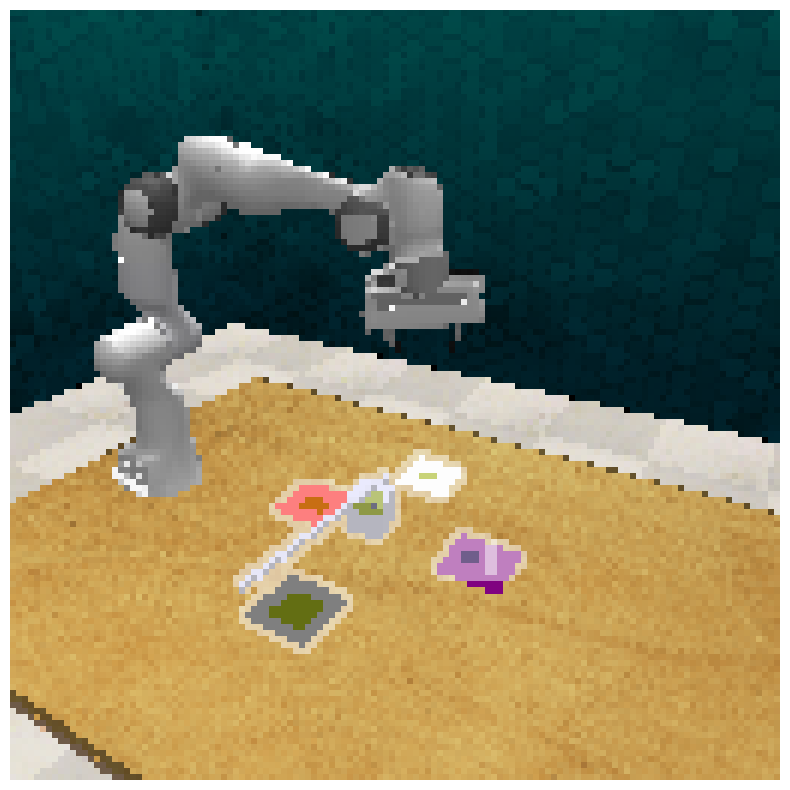

(37, 42, 3)


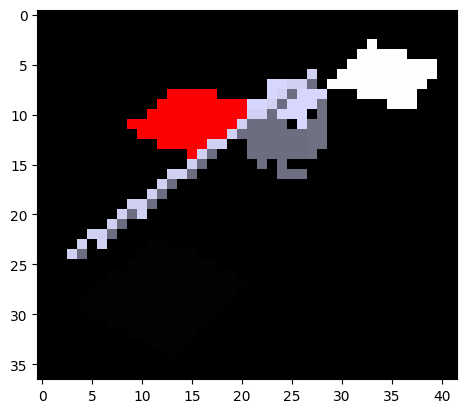

(10, 10, 3)


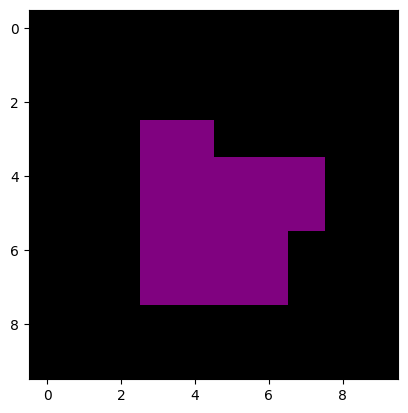

(12, 14, 3)


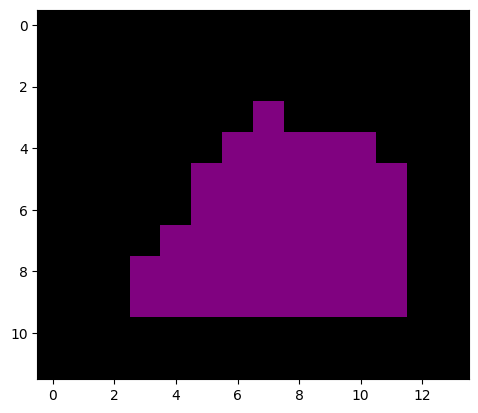

finish 1th view segment!


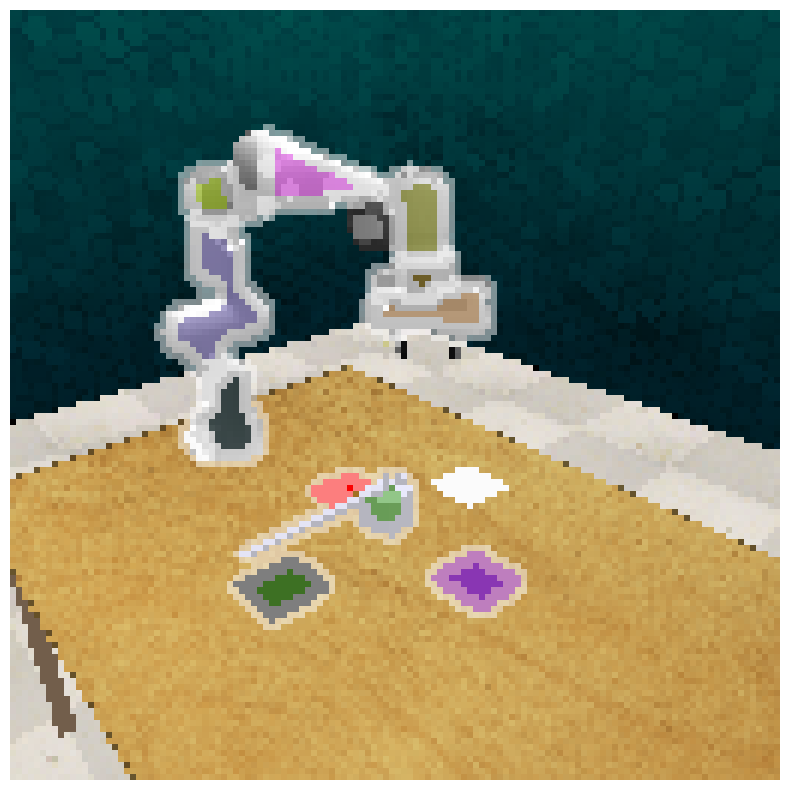

(34, 19, 3)


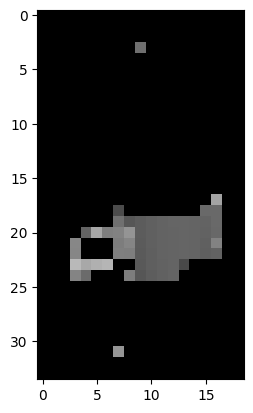

(23, 37, 3)


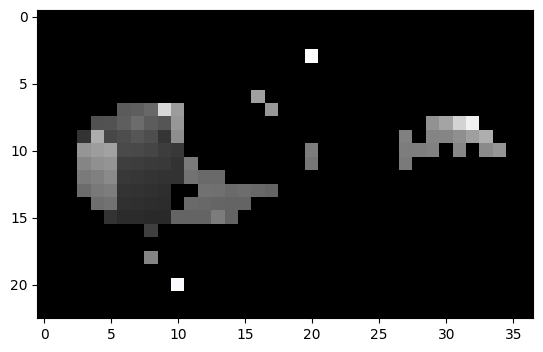

(22, 16, 3)


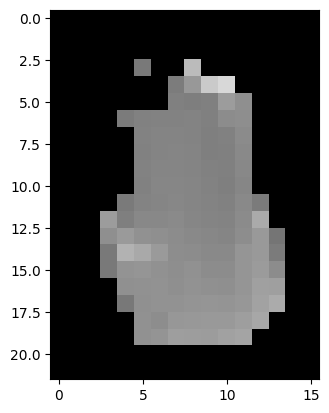

(20, 15, 3)


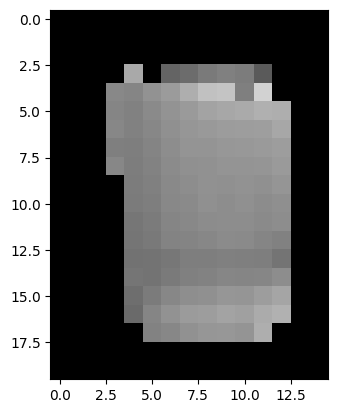

(15, 26, 3)


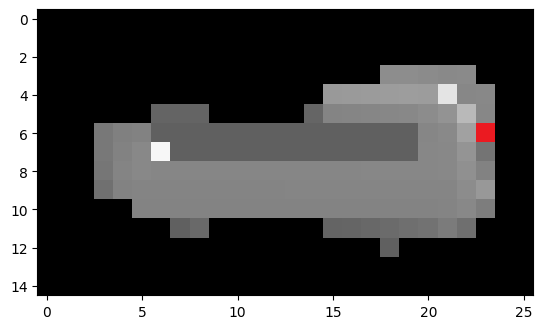

(19, 25, 3)


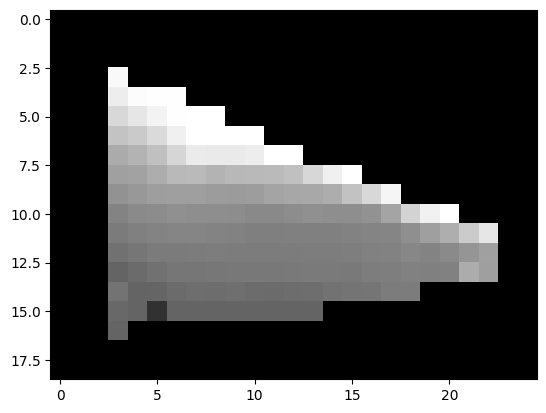

(46, 23, 3)


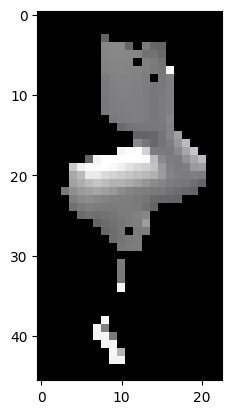

(30, 35, 3)


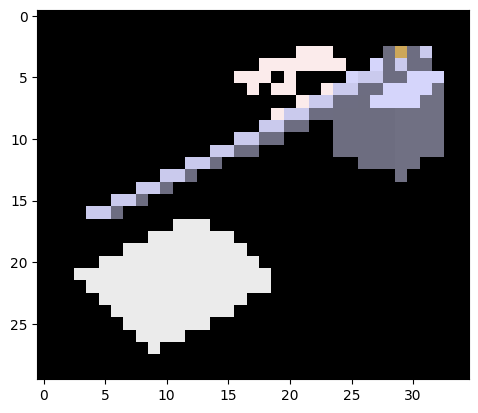

(15, 20, 3)


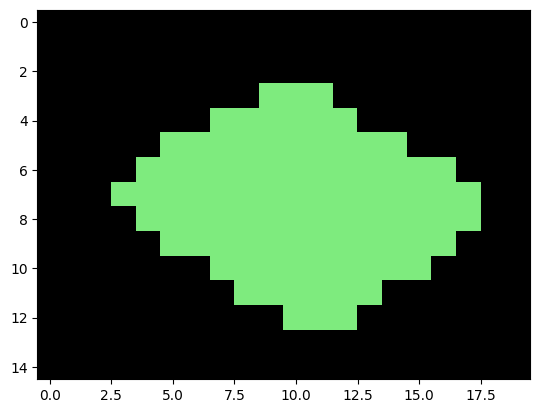

finish 2th view segment!


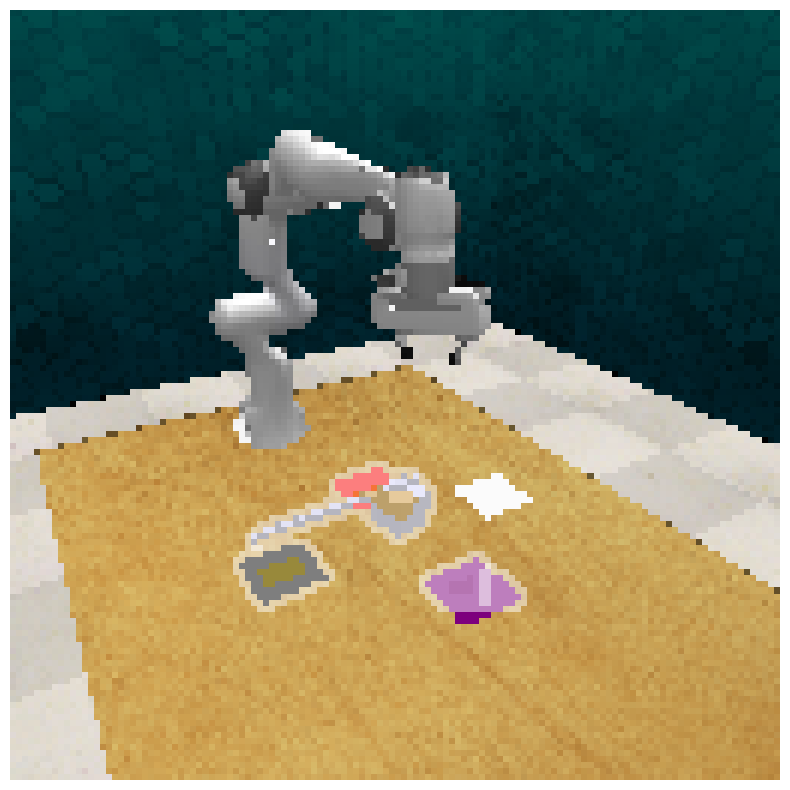

(18, 35, 3)


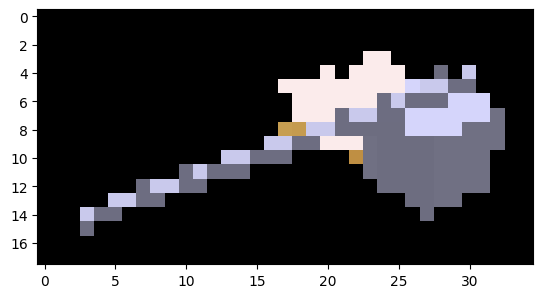

(15, 20, 3)


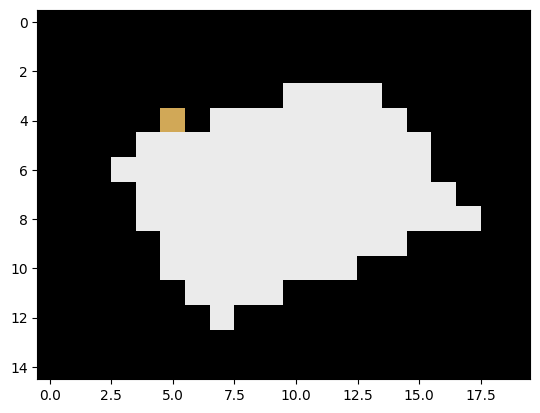

(11, 11, 3)


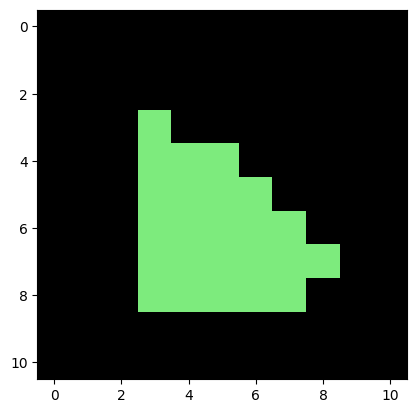

(13, 15, 3)


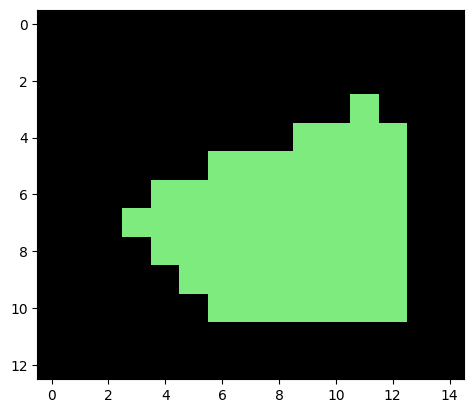

finish 3th view segment!


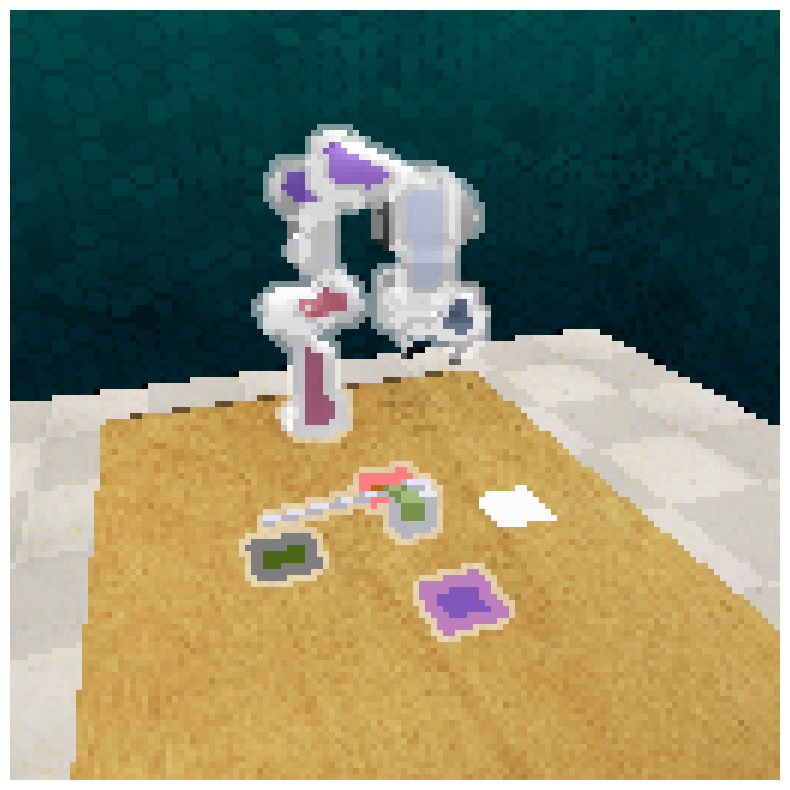

(33, 21, 3)


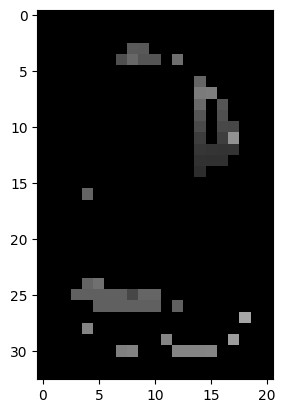

(25, 29, 3)


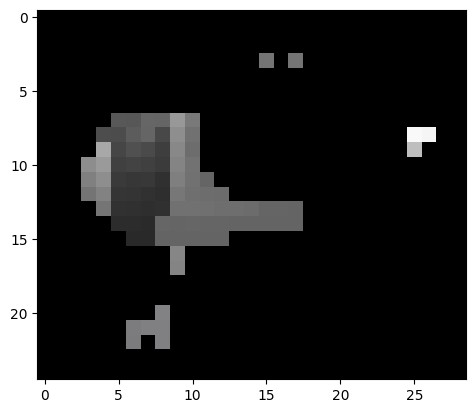

(17, 20, 3)


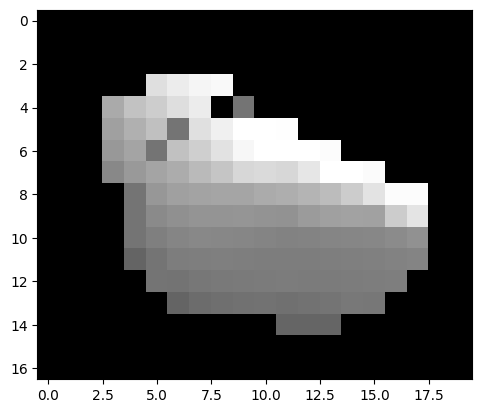

(19, 23, 3)


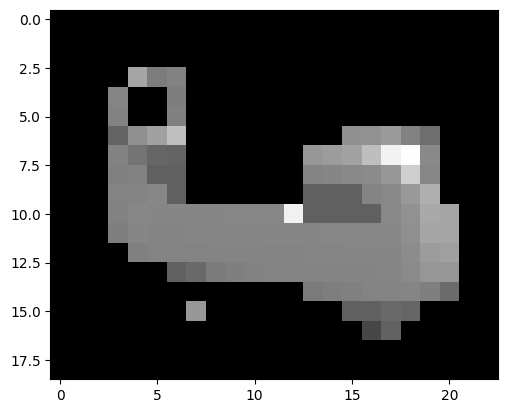

(32, 18, 3)


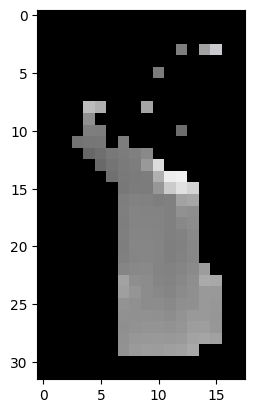

(40, 23, 3)


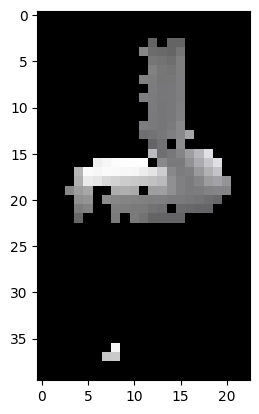

(26, 15, 3)


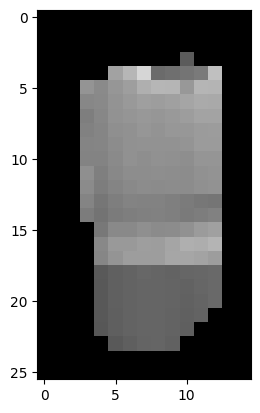

(24, 37, 3)


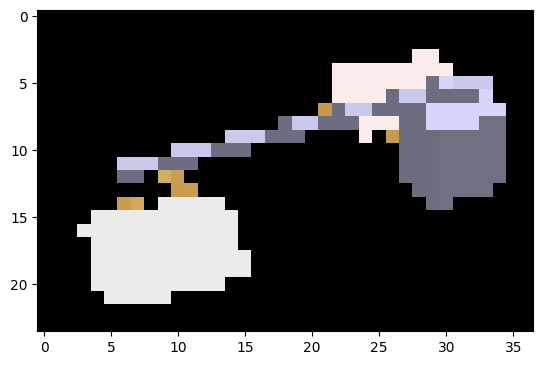

(16, 20, 3)


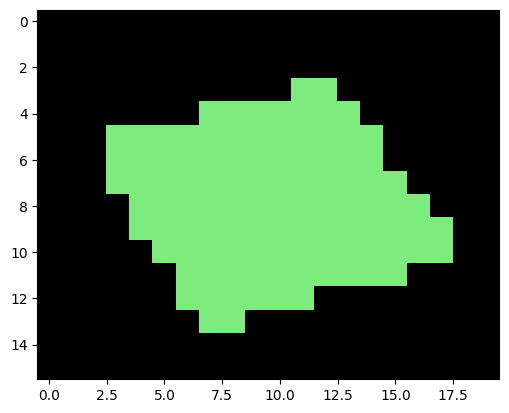

finish 4th view segment!


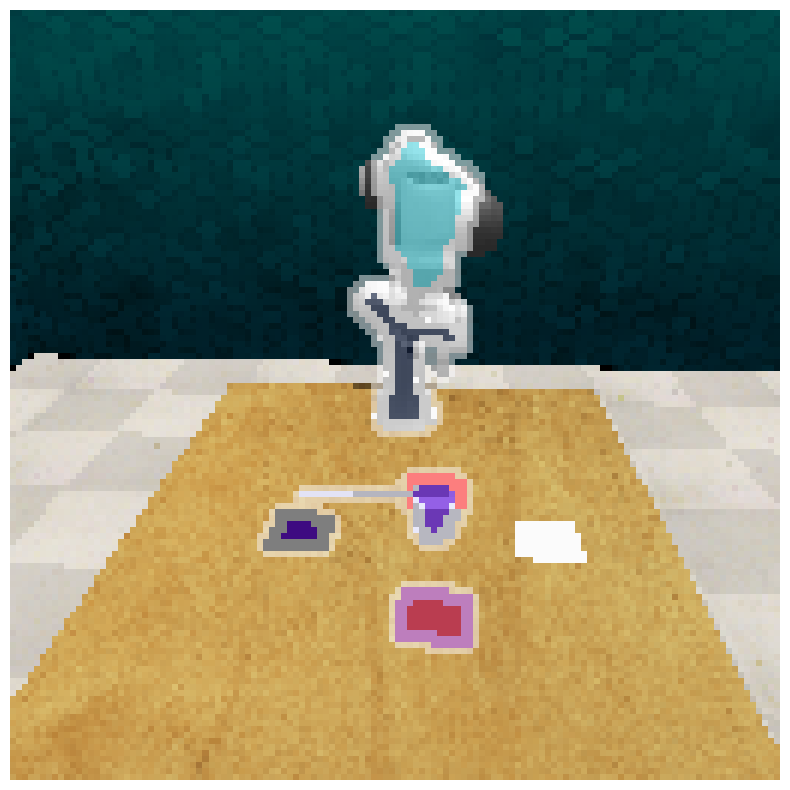

(31, 17, 3)


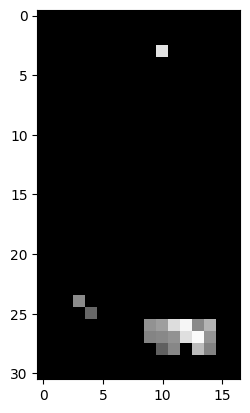

(30, 24, 3)


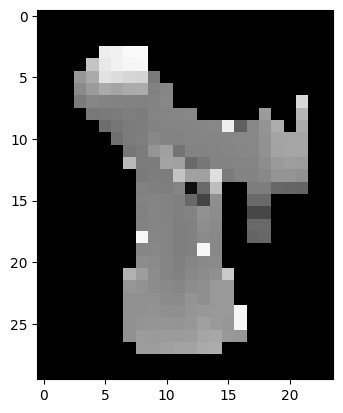

(33, 22, 3)


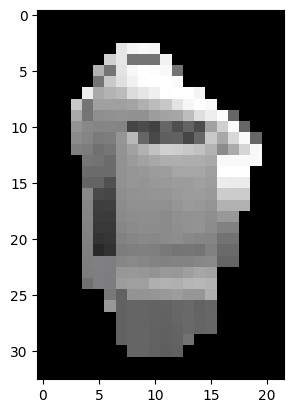

(18, 39, 3)


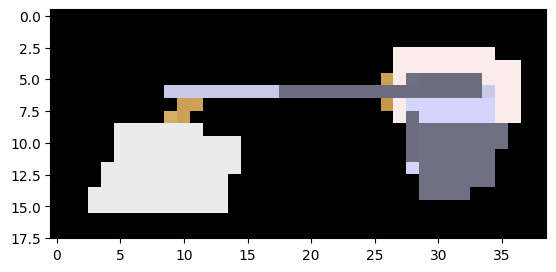

(15, 18, 3)


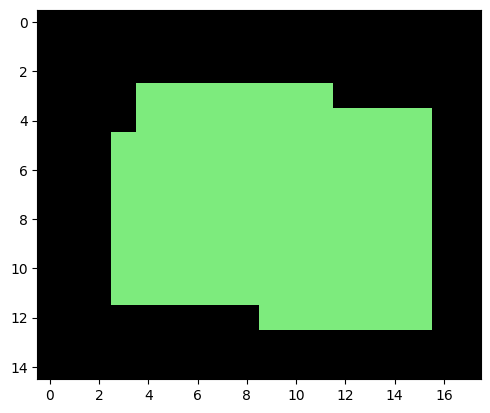

finish 5th view segment!


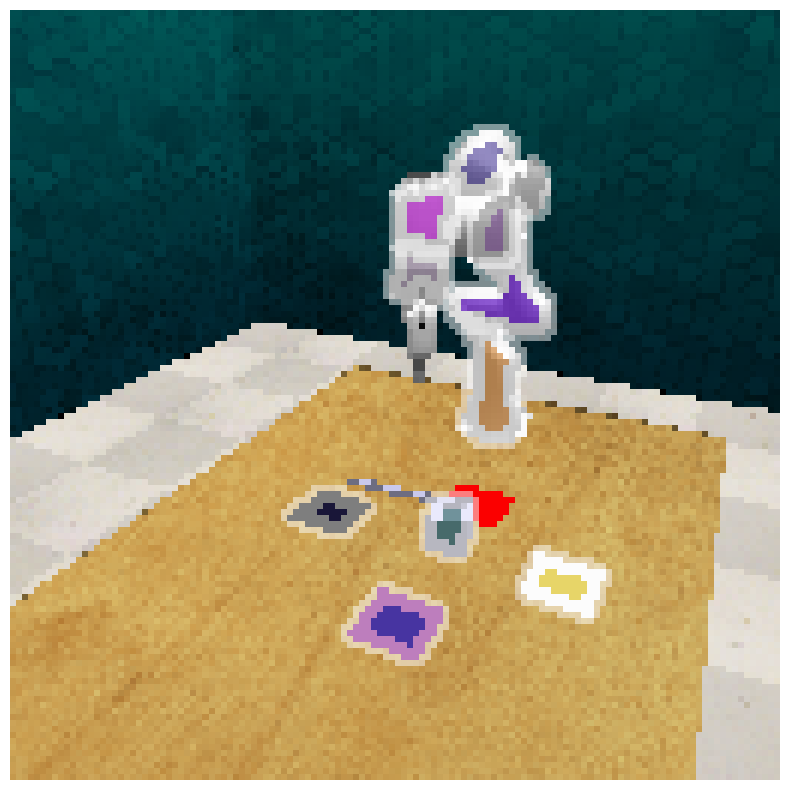

(26, 16, 3)


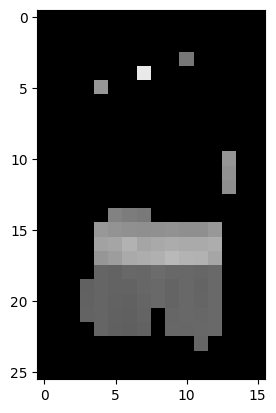

(16, 16, 3)


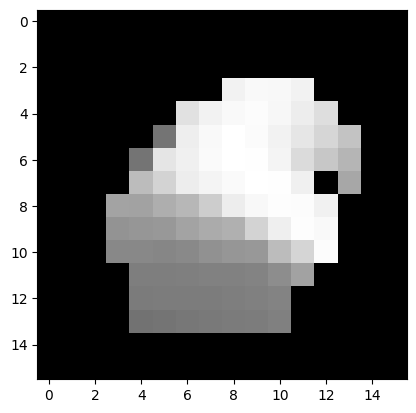

(17, 15, 3)


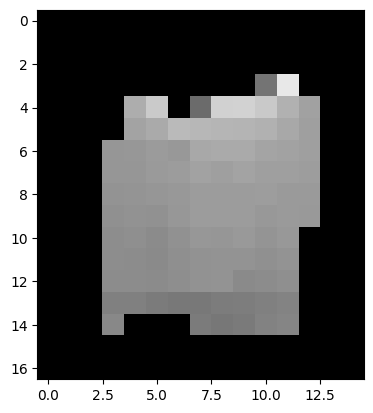

(22, 17, 3)


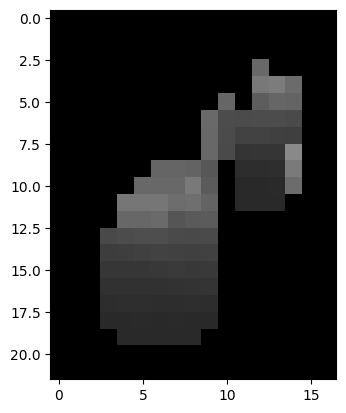

(27, 16, 3)


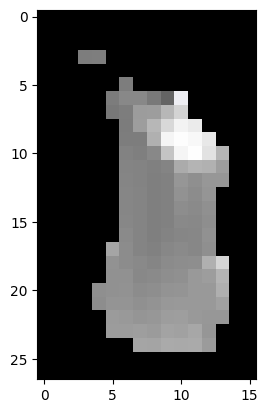

(42, 22, 3)


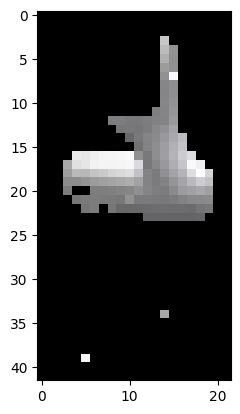

(12, 19, 3)


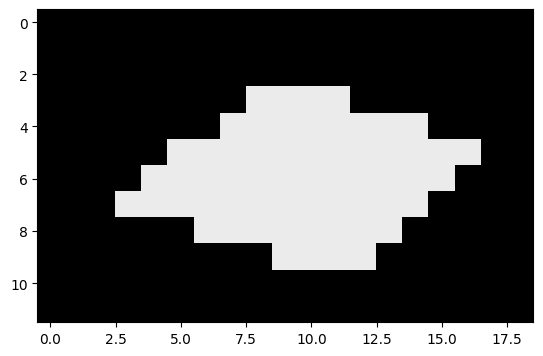

(15, 13, 3)


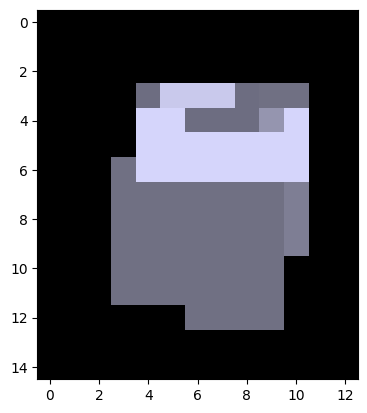

(16, 19, 3)


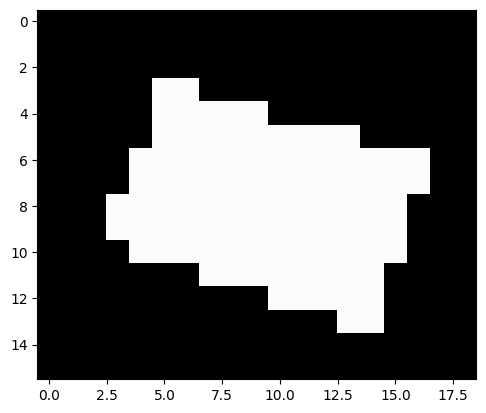

(17, 21, 3)


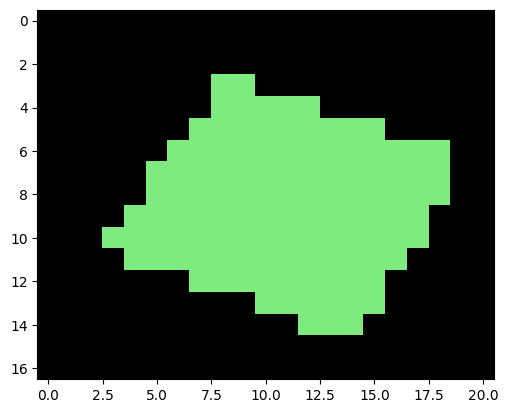

finish 6th view segment!


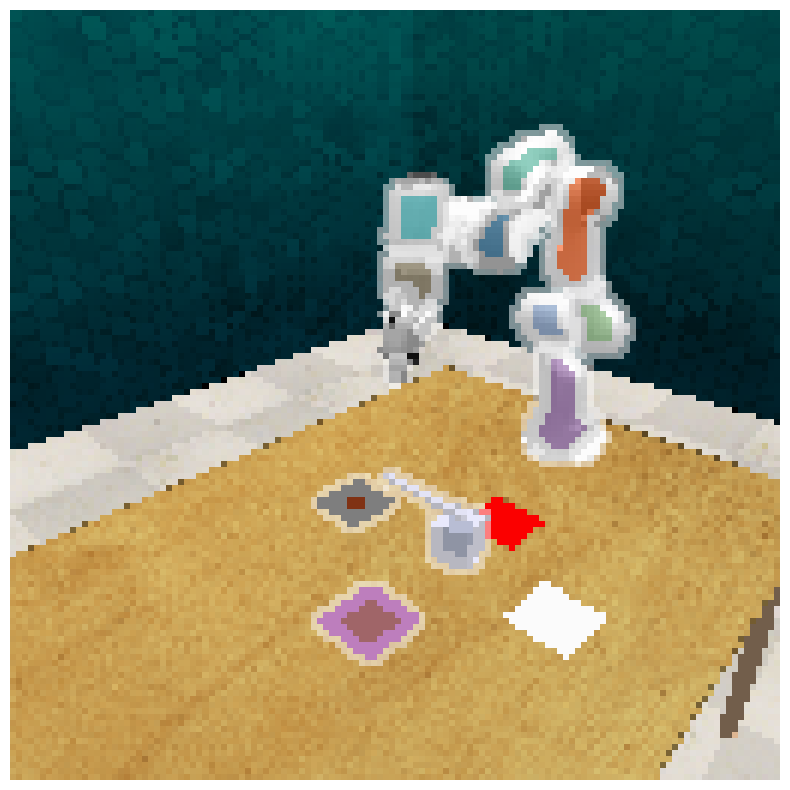

(35, 23, 3)


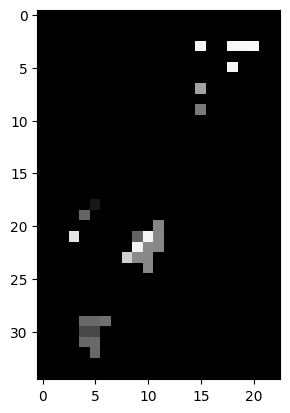

(15, 21, 3)


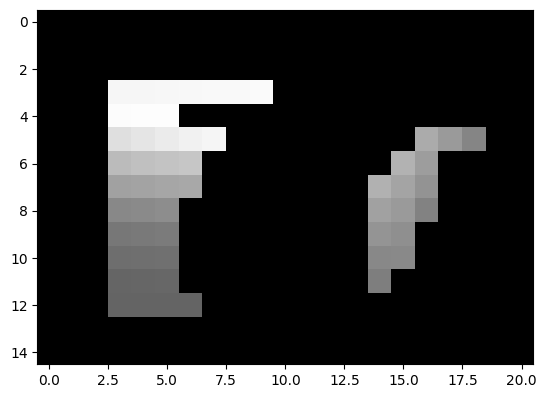

(33, 20, 3)


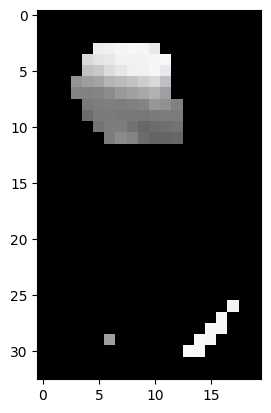

(18, 16, 3)


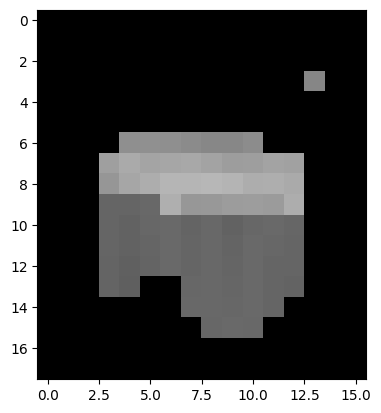

(17, 16, 3)


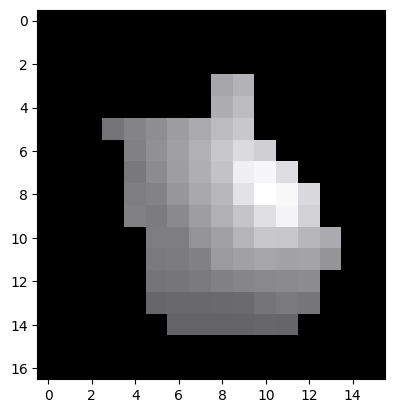

(17, 16, 3)


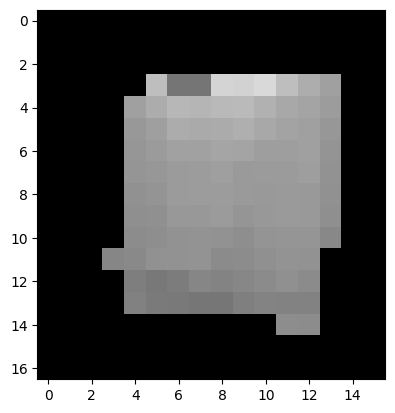

(26, 18, 3)


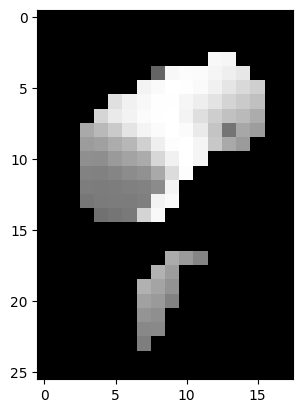

(24, 26, 3)


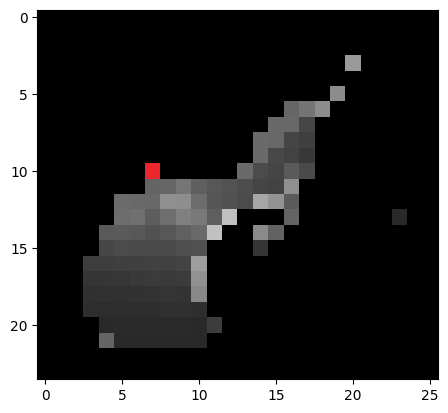

(24, 17, 3)


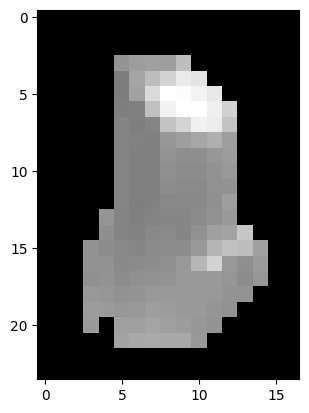

(26, 17, 3)


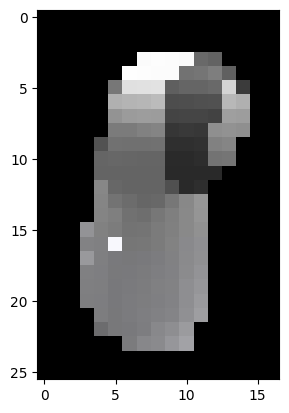

(21, 22, 3)


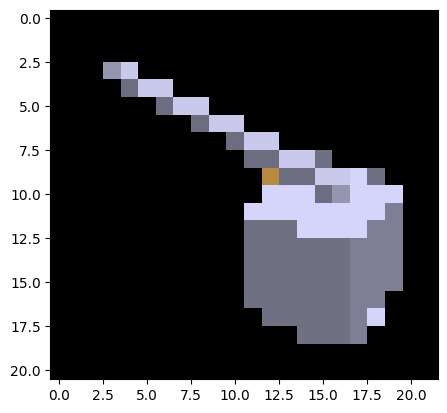

(13, 18, 3)


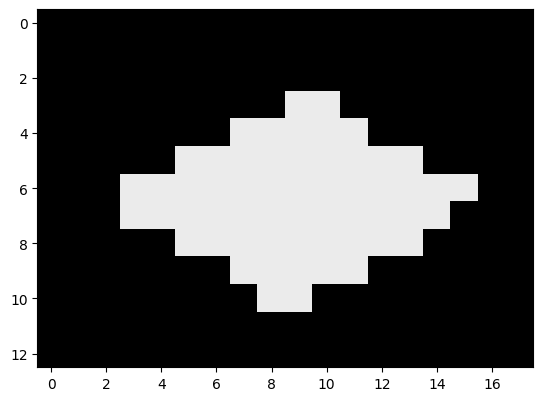

(17, 22, 3)


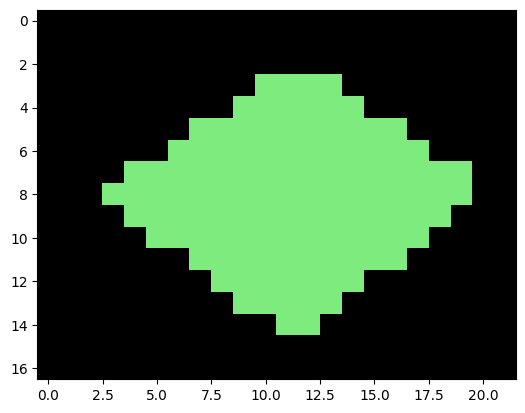

finish 7th view segment!


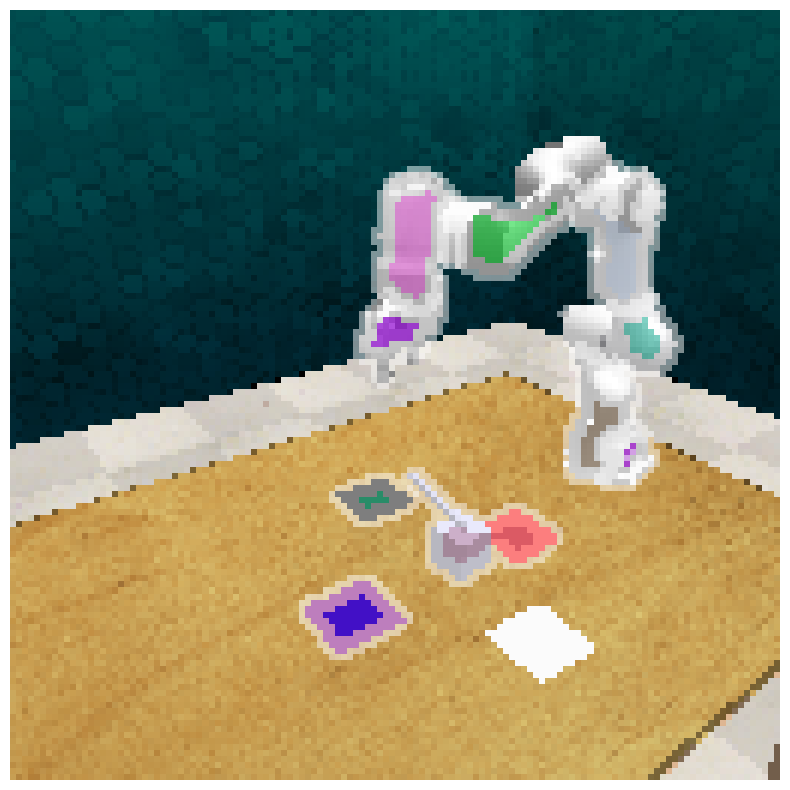

(34, 20, 3)


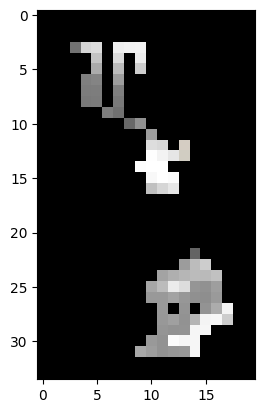

(39, 21, 3)


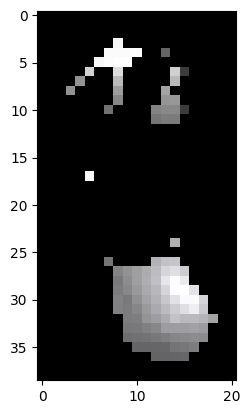

(27, 16, 3)


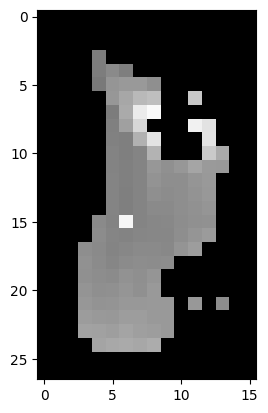

(40, 41, 3)


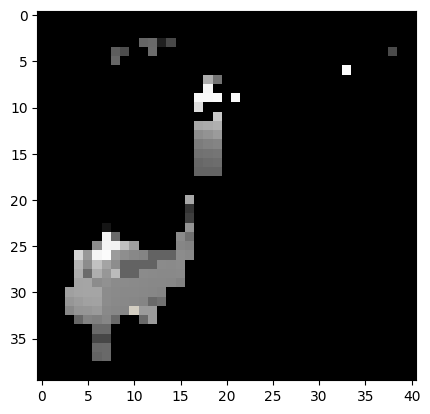

(21, 27, 3)


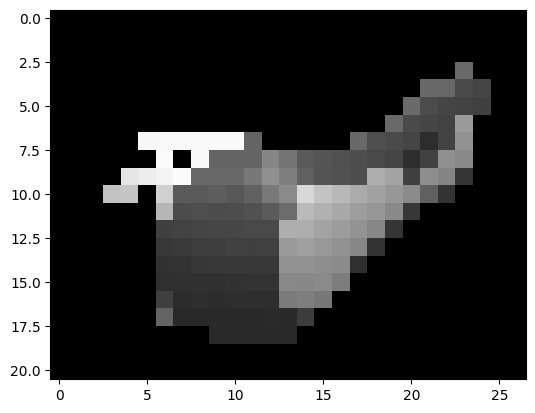

(28, 19, 3)


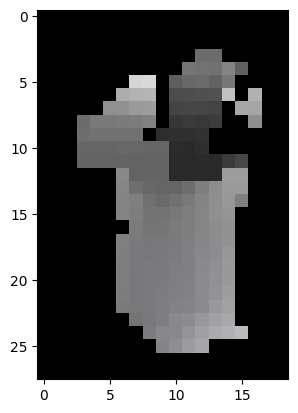

(27, 17, 3)


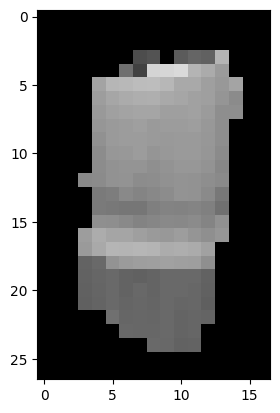

(23, 30, 3)


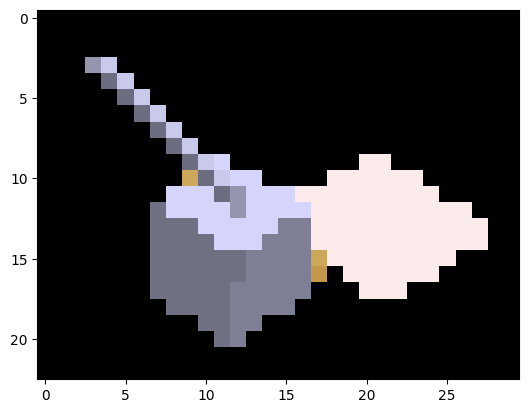

(12, 18, 3)


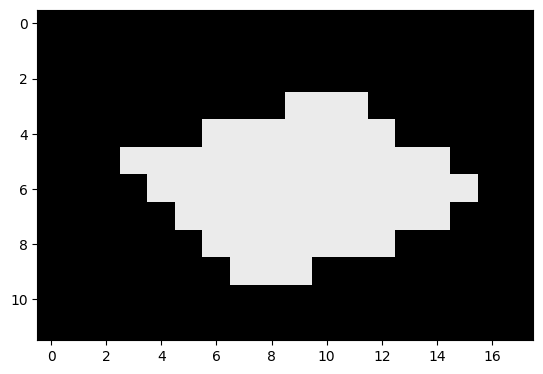

(17, 22, 3)


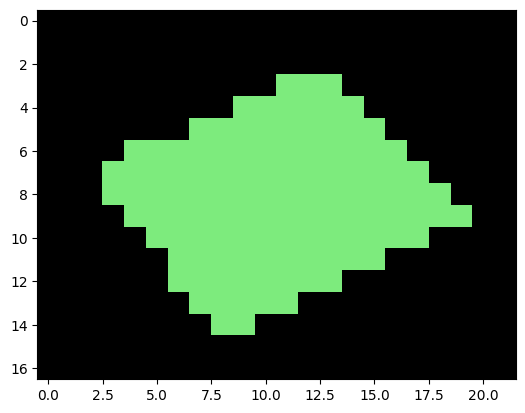

finish 8th view segment!


In [ ]:
'''
    这里对已经分割好的masked_images进行再一次的单独分割
    @ param: multi_view_masks           # 多视角下每个的mask
    @ param : mulit_view_masked_images  # 多视角下的每个mask分割出的图(masked_images.info['bbox']保存了边界信息)
    
'''
multi_view_sub_part_masks = []
multi_view_sub_part_images = []

for i in range(multi_view_nums):
    image, masks, masked_images = images[i], multi_view_masks[i], multi_view_maksed_images[i]
    
    this_view_masks = []
    this_view_sub_part_images = []
    
    
    # 使用clip找到robotarm
    robotarm_prompt = processor(text="RobotArm", return_tensors="pt")
    robotarm_embedding = clip.get_text_features(**robotarm_prompt)
    obj_embeddings = []
    # 对每张视角的图片的多个mask都进行分割
    for obj in masked_images:
        obj_image_processed_for_clip = processor(images=obj, return_tensors="pt", padding=True)
        obj_embeddings.append(clip.get_image_features(**obj_image_processed_for_clip))
        
    obj_embeddings = torch.cat(obj_embeddings, dim=0)
    similarity = (robotarm_embedding @ obj_embeddings.T).squeeze(0)  # 形状: [N]
    similarity_softmax = F.softmax(similarity, dim=0)  # 形状: [N]
    # 获取最相似的对象索引
    best_match_idx = similarity_softmax.argmax().item()
    
    
    # 对每张视角的图片的多个mask都进行分割
    for m in range(len(masked_images)):
        if m != best_match_idx: # 不是robotarm直接加入原来的就可以
            # 加入当前物体的mask
            this_view_masks.append([masks[m]])
            this_view_sub_part_images.append([masked_images[m]])
        else:   # 是robotarm，就进行sub_part的分割
            # print(len(masked_images))
            # print(obj.info['numpy_ver'].shape)
            obj = masked_images[m]
            
            this_view_one_obj_masks = []
            this_view_one_obj_sub_part_images = []
            
            # 获得单个物体的masks
            masks_single_obj = rough_mask_generator.generate(obj.info['numpy_ver'])
            # 数据处理
            for k in range(len(masks_single_obj)):
                # 将mask先反回粘贴到原来的大图片上
                masks_single_obj[k] =  map_masks_to_original(masks_single_obj[k]['segmentation'], obj.info['bbox'], np.array(image.convert("RGB")).squeeze().shape)
            
                # 获取原图的信息
                H_seg, W_seg, _ = obj.info['numpy_ver'].shape
                _, _, _, _, width, height = compute_bbox(masks_single_obj[k])
 
                # 把分割碎片通过阈值去除
                if np.count_nonzero(masks_single_obj[k]) / (H_seg * W_seg) > 0.01 \
                and np.count_nonzero(masks_single_obj[k]) / (H_seg * W_seg) <= 0.5\
                and np.count_nonzero(masks_single_obj[k]) > 15\
                and np.count_nonzero(masks_single_obj[k]) < 4900\
                and width / W_seg < 0.9 \
                and height / H_seg < 0.9\
                and compute_iou(masks[m], masks_single_obj[k]) > 0.05 :  # 分割后的与原来的重叠，如果不重合也删除
                    this_view_one_obj_masks.append(masks_single_obj[k])
            # 去除重复
            this_view_one_obj_masks = filter_large_duplicate_masks(this_view_one_obj_masks, ios_threshold=0.4)
            this_view_one_obj_masks_final = []
            # 数据处理
            for k in range(len(this_view_one_obj_masks)):
                # 获取原图的信息
                H_seg, W_seg, _ = obj.info['numpy_ver'].shape
                bbox = compute_bbox(this_view_one_obj_masks[k])
                if bbox is None:
                    continue  # 跳过无效的 mask
                _, _, _, _, width, height = bbox
                
                # 把分割碎片通过阈值去除
                if np.count_nonzero(this_view_one_obj_masks[k]) / (H_seg * W_seg) > 0.01 \
                and np.count_nonzero(this_view_one_obj_masks[k]) / (H_seg * W_seg) <= 0.5\
                and np.count_nonzero(this_view_one_obj_masks[k]) > 15\
                and np.count_nonzero(this_view_one_obj_masks[k]) < 4900\
                and width / W_seg < 0.9 \
                and height / H_seg < 0.9:
                # and compute_iou(masks[m], masks_single_obj[k]) > 0.1 :  # 分割后的与原来的重叠，如果不重合也删除
                    this_view_one_obj_masks_final.append(this_view_one_obj_masks[k])
            
            this_view_one_obj_sub_part_images = extract_masked_objects(np.array(image.convert("RGB")), this_view_one_obj_masks_final)  # 这里都已经归为到"原图坐标系 128*128"

            # 加入当前物体的mask
            this_view_masks.append(this_view_one_obj_masks_final)
            this_view_sub_part_images.append(this_view_one_obj_sub_part_images)
    
    # # 打印原图+mask
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for this_view_masks_of_single_obj in this_view_masks:
        for mask in this_view_masks_of_single_obj:
            show_mask(mask, plt.gca(), random_color=True, borders=True)
    plt.show()

    # # 打印单独的分割后的物体
    for this_view_sub_part_image_of_single_obj in this_view_sub_part_images:
        for sub_part_image in this_view_sub_part_image_of_single_obj:
            print(np.array(sub_part_image.convert("RGB")).shape)
            plt.imshow(sub_part_image)
            plt.show()
            
    # multi_view_sub_part_masks:List -> this_view_masks:List -> this_view_one_obj_masks_final:List -> sub_part_mask:np
    multi_view_sub_part_masks.append(this_view_masks)
    # multi_view_sub_part_images:List -> this_view_sub_part_images:List -> this_view_one_obj_sub_part_images:List -> sub_part_image:np
    multi_view_sub_part_images.append(this_view_sub_part_images)
    print(f"finish {i + 1}th view segment!")

In [ ]:
# 遍历每个视角的 masks 和对应的 image
processed_images = []  # 存储处理后的图片

for view_idx, (masks, image) in enumerate(zip(multi_view_sub_part_masks, images)):
    image_np = np.array(image, dtype=np.uint8)  # 转换为 NumPy 数组

    # 创建全 0 掩码，形状和图片相同
    combined_mask = np.zeros_like(image_np[:, :, 0])  # 只取单通道
    
    for obj_masks in masks:  # 遍历每个对象的 masks
        for mask in obj_masks:  # 遍历这个对象的多个 mask
            combined_mask = np.logical_or(combined_mask, mask)  # 叠加 mask
    
    # 把 mask 作用在原图上（保持原色，背景变黑）
    masked_image = image_np.copy()
    masked_image[~combined_mask] = 0  # 让 mask 外的部分变黑
    
    # 转回 PIL.Image 以便显示或保存
    processed_image = Image.fromarray(masked_image)
    processed_images.append(processed_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(processed_image)
    plt.show()